# Higher Education Outcomes Analysis

## 📄 Project Overview
This project aims to analyze factors impacting the median earnings of college graduates ten years after enrollment. Using data from the U.S. Department of Education's College Scorecard, we examine various institutional characteristics, such as cost of attendance and institution type, to understand their effects on student outcomes.

---

## Imports

In [2]:
# Importing necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Additional imports for statistical analysis and machine learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

## Data Loading and Initial Exploration

To start, we’ll load the College Scorecard dataset to understand its structure and get an overview of the data available for analysis. This includes examining the dataset size, columns, data types, and checking for missing values.


In [3]:
# Importing dataset
df = pd.read_csv('C:/Users/ajten/Downloads/College_Scorecard_Raw_Data_10022024/College_Scorecard_Raw_Data_09242024/MERGED2014_15_PP.csv')

# Variables to keep 
variables = [
    'CONTROL', 'UGDS','AVGFACSAL', 'PCTPELL', 'COSTT4_A', 'COSTT4_P', 'MD_FAMINC',
    'MD_EARN_WNE_P10', 'INEXPFTE', 'C150_4', 'C150_L4', 'PCTFLOAN', 'DEBT_MDN', 
    'PCIP14', 'PCIP11', 'PCIP15', 'PCIP52', 'STUFACR'
]

# Subset the dataframe
df = df[variables]

# Shows data types, non-null counts, and memory usage
df.info()

C:\Users\ajten\AppData\Local\Temp\ipykernel_3708\1555876259.py:2: DtypeWarning: Columns (1537,1540,1542,1575,1589,1606,1610,1614,1615,1729,1909,1910,1911,1912,1913) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/ajten/Downloads/College_Scorecard_Raw_Data_10022024/College_Scorecard_Raw_Data_09242024/MERGED2014_15_PP.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CONTROL          7766 non-null   int64  
 1   UGDS             7037 non-null   float64
 2   AVGFACSAL        4579 non-null   float64
 3   PCTPELL          7007 non-null   float64
 4   COSTT4_A         4037 non-null   float64
 5   COSTT4_P         2582 non-null   float64
 6   MD_FAMINC        7546 non-null   object 
 7   MD_EARN_WNE_P10  6951 non-null   object 
 8   INEXPFTE         7324 non-null   float64
 9   C150_4           2497 non-null   float64
 10  C150_L4          3946 non-null   float64
 11  PCTFLOAN         7007 non-null   float64
 12  DEBT_MDN         7709 non-null   object 
 13  PCIP14           7035 non-null   float64
 14  PCIP11           7035 non-null   float64
 15  PCIP15           7035 non-null   float64
 16  PCIP52           7035 non-null   float64
 17  STUFACR       

## Data Cleaning

This section prepares the data by handling missing values, converting data types, and creating new variables.


In [4]:
for col in df.columns:
    if 'PS' in df[col].values:
        print(f"Column '{col}' contains 'PS'")

Column 'MD_FAMINC' contains 'PS'
Column 'MD_EARN_WNE_P10' contains 'PS'
Column 'DEBT_MDN' contains 'PS'


In [5]:
# Replace 'PrivacySuppressed' (PS) with NaN and convert to numeric
columns_to_clean = ['MD_EARN_WNE_P10', 'MD_FAMINC', 'DEBT_MDN']
df[columns_to_clean] = df[columns_to_clean].replace('PS', np.nan)
for col in columns_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any NaN values exist in the specified columns to clean
df_clean = df.dropna(subset=columns_to_clean).copy()

# Create new variables for completion rate and attendance cost
df_clean['completion_rate'] = df_clean['C150_4'].combine_first(df_clean['C150_L4'])
df_clean['avg_attendance'] = df_clean['COSTT4_A'].combine_first(df_clean['COSTT4_P'])

# Handle missing values in critical variables and make a copy
critical_vars = ['UGDS','AVGFACSAL','PCTPELL','INEXPFTE', 'completion_rate', 'avg_attendance', 'DEBT_MDN']
df_clean = df_clean.dropna(subset=critical_vars).copy()

# Binary institution type (public/private) and STEM Index
df_clean['public_private'] = df_clean['CONTROL'].apply(lambda x: 0 if x == 1 else 1)
df_clean['STEM_Index'] = df_clean['PCIP14'] + df_clean['PCIP11'] + df_clean['PCIP15'] + df_clean['PCIP52']

# Drop redundant columns
df3 = df_clean.drop(['CONTROL', 'C150_4', 'C150_L4', 'COSTT4_A', 'COSTT4_P'], axis=1)

# Final check on cleaned dataset
print("Cleaned Dataset Shape:", df3.shape)
df3.info()

Cleaned Dataset Shape: (3589, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 3589 entries, 0 to 7333
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UGDS             3589 non-null   float64
 1   AVGFACSAL        3589 non-null   float64
 2   PCTPELL          3589 non-null   float64
 3   MD_FAMINC        3589 non-null   float64
 4   MD_EARN_WNE_P10  3589 non-null   float64
 5   INEXPFTE         3589 non-null   float64
 6   PCTFLOAN         3589 non-null   float64
 7   DEBT_MDN         3589 non-null   float64
 8   PCIP14           3589 non-null   float64
 9   PCIP11           3589 non-null   float64
 10  PCIP15           3589 non-null   float64
 11  PCIP52           3589 non-null   float64
 12  STUFACR          3589 non-null   float64
 13  completion_rate  3589 non-null   float64
 14  avg_attendance   3589 non-null   float64
 15  public_private   3589 non-null   int64  
 16  STEM_Index       3589 non-null 

## Exploratory Data Analysis (EDA)

In this section, we explore patterns and relationships in the data to understand factors that may influence **median earnings 10 years after entry**. We use visualizations to examine distribution and relationships between key variables.


In [6]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df3[['public_private', 'UGDS','AVGFACSAL', 'PCTPELL', 'avg_attendance', 'MD_FAMINC',
    'MD_EARN_WNE_P10', 'INEXPFTE', 'completion_rate', 'PCTFLOAN', 'DEBT_MDN', 
    'PCIP14', 'PCIP11', 'PCIP15', 'PCIP52', 'STUFACR']].describe())

Descriptive Statistics:
       public_private           UGDS     AVGFACSAL      PCTPELL  \
count     3589.000000    3589.000000   3589.000000  3589.000000   
mean         0.599889    4206.743661   6323.631931     0.479273   
std          0.489989    7000.771397   2197.685680     0.203945   
min          0.000000      18.000000    748.000000     0.064000   
25%          0.000000     578.000000   4866.000000     0.324400   
50%          1.000000    1654.000000   6092.000000     0.446300   
75%          1.000000    4694.000000   7517.000000     0.632100   
max          1.000000  151558.000000  20650.000000     1.000000   

       avg_attendance      MD_FAMINC  MD_EARN_WNE_P10       INEXPFTE  \
count     3589.000000    3589.000000      3589.000000    3589.000000   
mean     25536.773475   33184.548342     37166.898858    7345.174979   
std      12804.929725   21595.200226     11335.022920    6335.170234   
min       6039.000000       0.000000     15100.000000     310.000000   
25%      149

### Figure 1: Distribution of Median Earnings 10 Years After Entry

This histogram shows the distribution of median earnings 10 years after enrollment. The data appears right-skewed, with most institutions clustering around earnings between $30,000 and $50,000.


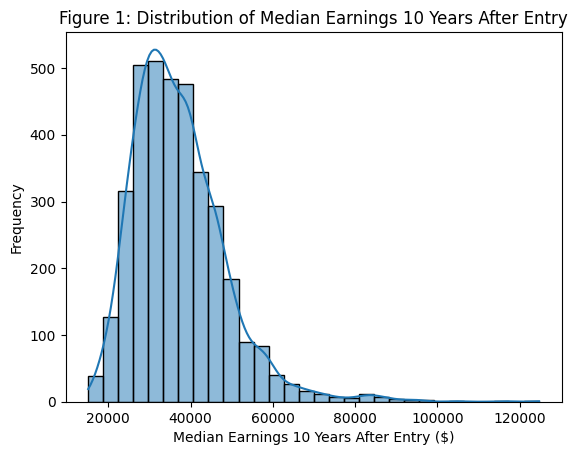

In [7]:
# Code for Figure 1: Distribution of Median Earnings
sns.histplot(df3['MD_EARN_WNE_P10'], bins=30, kde=True)
plt.title('Figure 1: Distribution of Median Earnings 10 Years After Entry')
plt.xlabel('Median Earnings 10 Years After Entry ($)')
plt.ylabel('Frequency')
plt.show()

### Figure 2: Median Earnings by Institution Type

This box plot compares median earnings for graduates of public and private institutions. While there is some overlap, private institutions generally exhibit a slightly higher median earnings range, though with a broader spread and more outliers at the higher end.


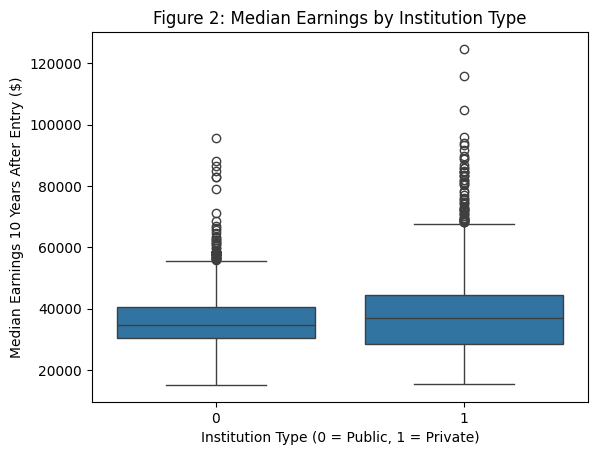

In [8]:
# Code for Figure 2: Median Earnings by Institution Type
sns.boxplot(x='public_private', y='MD_EARN_WNE_P10', data=df3)
plt.title("Figure 2: Median Earnings by Institution Type")
plt.xlabel("Institution Type (0 = Public, 1 = Private)")
plt.ylabel("Median Earnings 10 Years After Entry ($)")
plt.show()

### Figure 3: Average Cost of Attendance by Institution Type

This bar plot shows that private institutions have a significantly higher average cost of attendance compared to public institutions. This difference in cost might play a role in the differences in median earnings between institution types.


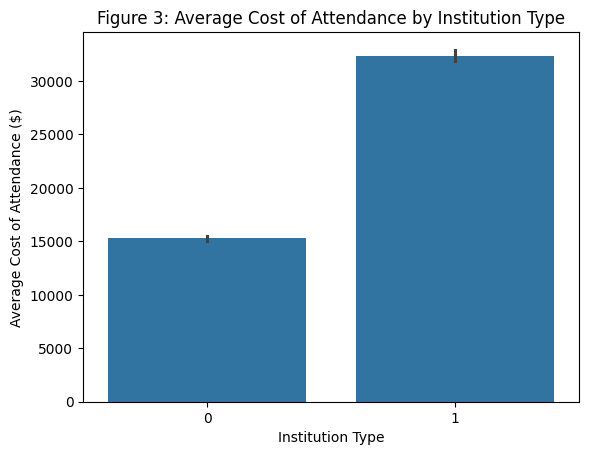

In [9]:
# Code for Figure 3: Average Cost of Attendance by Institution Type
sns.barplot(x='public_private', y='avg_attendance', data=df3)
plt.title("Figure 3: Average Cost of Attendance by Institution Type")
plt.xlabel("Institution Type")
plt.ylabel("Average Cost of Attendance ($)")
plt.show()

### Figure 4: Average Faculty Salary vs. Median Earnings by Institution Type

This scatter plot displays the relationship between average faculty salary and median earnings, colored by institution type. There is a positive trend, suggesting that institutions with higher faculty salaries tend to have higher median earnings among graduates. Private institutions are distributed across a wider range of faculty salaries.


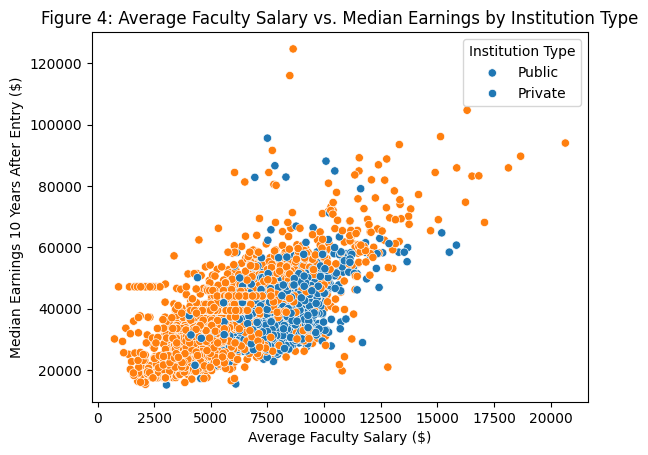

In [10]:
# Code for Figure 4: Average Faculty Salary vs. Median Earnings by Institution Type
sns.scatterplot(x='AVGFACSAL', y='MD_EARN_WNE_P10', hue='public_private', data=df3)
plt.title("Figure 4: Average Faculty Salary vs. Median Earnings by Institution Type")
plt.xlabel("Average Faculty Salary ($)")
plt.ylabel("Median Earnings 10 Years After Entry ($)")
plt.legend(title="Institution Type", labels=["Public", "Private"])
plt.show()

### Figure 5: Median Earnings vs. Family Income

This scatter plot shows the relationship between family income and median earnings, with point colors representing the percentage of Pell Grant recipients. There is a positive trend, indicating that higher family income is associated with higher median earnings. Schools with higher Pell Grant recipient percentages are mostly concentrated at the lower end of family income, suggesting that Pell Grants serve lower-income students.


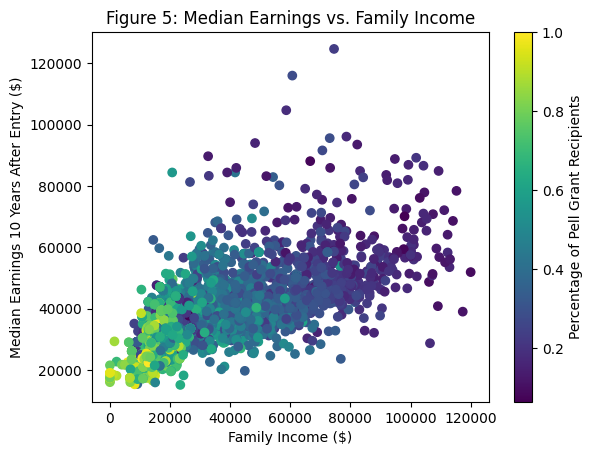

In [11]:
# Code for Figure 5: Median Earnings vs. Family Income
plt.scatter(df3['MD_FAMINC'], df3['MD_EARN_WNE_P10'], c=df3['PCTPELL'], cmap='viridis')
plt.colorbar(label="Percentage of Pell Grant Recipients")
plt.title("Figure 5: Median Earnings vs. Family Income")
plt.xlabel("Family Income ($)")
plt.ylabel("Median Earnings 10 Years After Entry ($)")
plt.show()

### Correlation Matrix Heatmap

This heatmap shows the correlation coefficients between various features and the target variable, **Median Earnings 10 Years After Entry** (`MD_EARN_WNE_P10`). High positive or negative correlations with `MD_EARN_WNE_P10` indicate strong relationships that might be valuable in our predictive model.

- **High Positive Correlations**: `MD_FAMINC` (Family Income) and `AVGFACSAL` (Average Faculty Salary) show strong positive correlations with median earnings, suggesting that students from higher-income families and institutions with higher faculty salaries tend to earn more.
- **High Negative Correlations**: `PCTPELL` (Percentage of Pell Grant Recipients) has a notable negative correlation with median earnings, indicating that institutions with a higher proportion of Pell Grant recipients tend to have lower median earnings.
- **Other Notable Correlations**: `avg_attendance` (Average Cost of Attendance) and `DEBT_MDN` (Median Debt) also show moderate positive correlations with earnings, potentially reflecting the impact of cost and debt on long-term outcomes.

This matrix helps identify key variables to focus on in our predictive model.

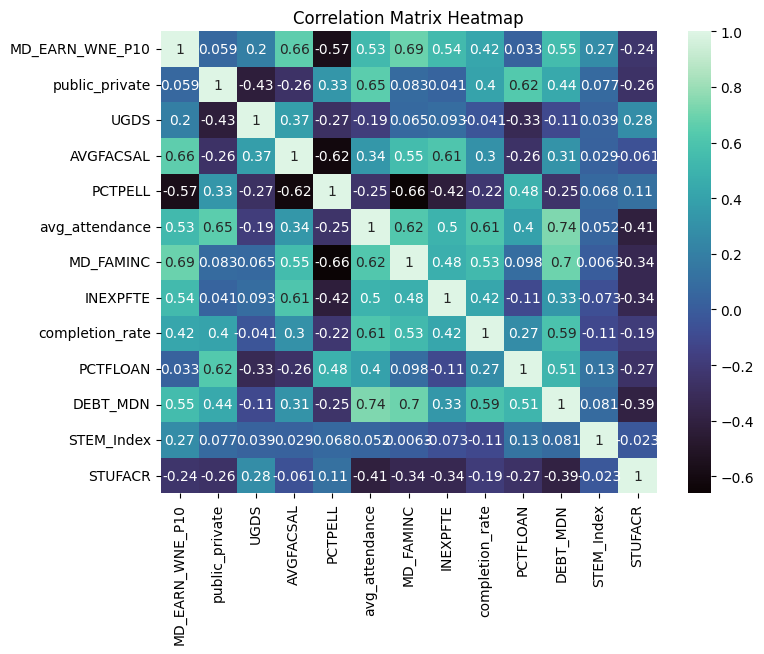

In [12]:
# Code for Correlation matrix
corr_vars = ['MD_EARN_WNE_P10','public_private', 'UGDS','AVGFACSAL', 'PCTPELL', 'avg_attendance', 'MD_FAMINC',
    'INEXPFTE', 'completion_rate', 'PCTFLOAN', 'DEBT_MDN', 
    'STEM_Index', 'STUFACR']
corr_matrix = df3[corr_vars].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='mako')
plt.title('Correlation Matrix Heatmap')
plt.show()

### EDA Summary

- **Median Earnings Distribution**: The distribution of median earnings is right-skewed, with most institutions showing median earnings between $30,000 and $50,000.
- **Institution Type**: Private institutions generally have a higher range of median earnings, though they also exhibit more variability and outliers.
- **Cost of Attendance**: Private institutions have a significantly higher average cost of attendance compared to public institutions.
- **Faculty Salary and Earnings**: There is a positive relationship between average faculty salary and graduate earnings, with higher faculty salaries generally associated with higher median earnings.
- **Family Income and Pell Grant Recipients**: Higher family income correlates with higher median earnings. Institutions with a higher percentage of Pell Grant recipients tend to serve lower-income students, which could affect earnings outcomes.


## Model Training and Evaluation (Random Forest)

In this section, we use a **Random Forest Regressor** to predict median earnings 10 years after enrollment based on institutional characteristics. This model helps capture non-linear relationships and interactions between variables.


In [13]:
X = df3[['UGDS','AVGFACSAL', 'PCTPELL', 'avg_attendance', 'MD_FAMINC',
    'completion_rate','DEBT_MDN', 'STEM_Index', 'INEXPFTE']] # Removing pub_priv - feature importance
y = df3['MD_EARN_WNE_P10']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

# Cross-validation for robustness (if needed)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")

Test Set Mean Squared Error: 29634976.4420
Test Set Root Mean Squared Error: 5443.8017
Test Set R-squared: 0.7631
Cross-Validation R² Scores: [0.7502491  0.75319308 0.70259163 0.79613627 0.52901419]
Mean R² Score: 0.7062


In [14]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

           Feature  Importance
4        MD_FAMINC    0.444224
1        AVGFACSAL    0.211513
7       STEM_Index    0.091898
5  completion_rate    0.057134
6         DEBT_MDN    0.044572
0             UGDS    0.043679
3   avg_attendance    0.041943
2          PCTPELL    0.037963
8         INEXPFTE    0.027074


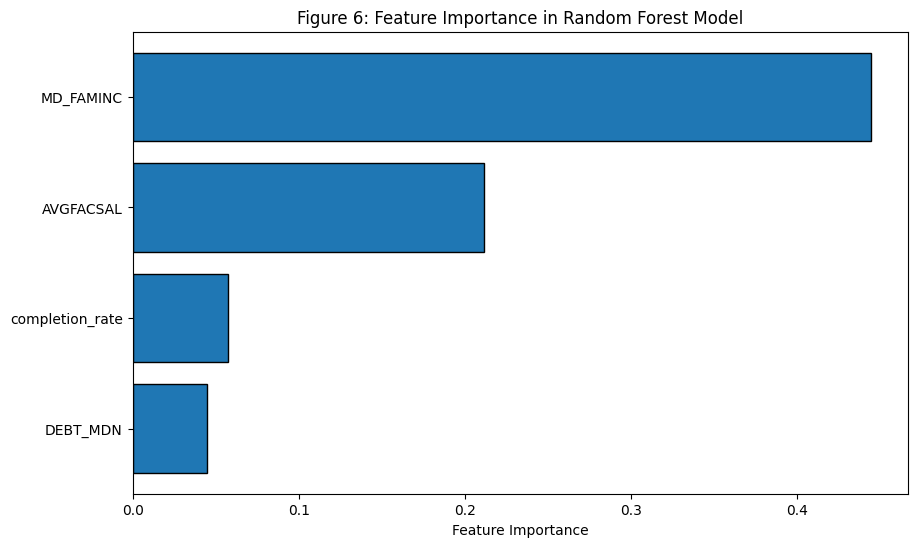

In [15]:
# Barplot
features = ['MD_FAMINC', 'AVGFACSAL', 'completion_rate', 'DEBT_MDN']
importances = [0.444224, 0.211513, 0.057134, 0.044572]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, edgecolor='black')
plt.xlabel('Feature Importance')
plt.title('Figure 6: Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

### Model Summary and Interpretation (Random Forest)

- **Mean Squared Error (MSE)**: The test set MSE is approximately 29,634,976, which represents the average squared difference between actual and predicted earnings.
- **Root Mean Squared Error (RMSE)**: The test set RMSE is around 5,443, indicating the average prediction error in the unit of earnings. This provides a more interpretable metric than MSE.
- **R-squared (R²)**: The test set R² score is 0.7631, meaning the model explains about 76.31% of the variance in median earnings on the test data, indicating strong predictive power.
- **Cross-Validation R² Scores**: The cross-validation R² scores ranged from 0.529 to 0.796, with a mean score of 0.7062. This variation suggests that the model may be slightly overfitting, but it still generalizes reasonably well across different subsets of the data.

- **Feature Importances**:
  - **MD_FAMINC (Family Income)** is the most important feature with an importance score of 0.444, suggesting a strong relationship with median earnings.
  - **AVGFACSAL (Average Faculty Salary)** and **STEM_Index** also have significant contributions, with importance scores of 0.211 and 0.092, respectively.
  - Features like **completion_rate**, **DEBT_MDN (Median Debt)**, and **UGDS (Undergraduate Enrollment)** provide additional predictive power, though to a lesser extent.

- **Dropping `public_private`**: The feature `public_private` was dropped due to its low feature importance in the initial model setup, indicating it does not significantly contribute to the predictive accuracy.

The results highlight **Family Income** and **Average Faculty Salary** as the most influential factors in predicting earnings, with **STEM_Index** added as a proxy to boost predictive power. These findings suggest that socioeconomic factors and institutional resources play a critical role in graduates’ median earnings 10 years after enrollment.


### Hyperparameter Tuning

To improve the model's performance, we performed hyperparameter tuning using `RandomizedSearchCV`. This approach tests multiple combinations of hyperparameters to find the best-performing set. The parameters tuned include:
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of each tree
- **min_samples_split**: Minimum number of samples required to split an internal node
- **min_samples_leaf**: Minimum number of samples required to be at a leaf node
- **max_features**: Number of features to consider when looking for the best split

After running RandomizedSearchCV with 5-fold cross-validation, we selected the best parameters and evaluated the tuned model's performance on the test set.


In [16]:
# Refine the parameter grid based on the best found parameters
param_dist = {
    'n_estimators': [150, 200, 250],  # Narrowing around the best n_estimators found
    'max_depth': [15, 20, 25],        # Fine-tuning around the best max_depth found
    'min_samples_split': [2, 5],      # Exploring small changes in min_samples_split
    'min_samples_leaf': [1, 2],       # Testing small changes in min_samples_leaf
    'max_features': ['sqrt', 'log2']  # Only valid options for max_features
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=10,  # Number of random combinations to test
                                   cv=5, random_state=42, n_jobs=-1, verbose=2)

# Fit the model to your training data
random_search.fit(X_train, y_train)

# Best hyperparameters from the random search
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Tuned Random Forest MSE:", mean_squared_error(y_test, y_pred))
print("Tuned Random Forest R-squared:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\ajten\Downloads\Python Code - DATA4310\envPython312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}
Tuned Random Forest MSE: 28803835.272960376
Tuned Random Forest R-squared: 0.7696993456464942


### Tuned Model Performance Evaluation

The best hyperparameters found were:
- **n_estimators**: 250
- **max_depth**: 25
- **min_samples_split**: 2
- **min_samples_leaf**: 1
- **max_features**: 'log2'

The tuned Random Forest model achieved the following performance metrics on the test set:
- **Mean Squared Error (MSE)**: 28,803,835.27
- **R-squared (R²)**: 0.7697

These metrics indicate an improvement in the model's ability to predict median earnings. The R² score of 0.7697 shows that the tuned model explains approximately 76.97% of the variance in median earnings, which is slightly higher than the baseline model, suggesting better predictive performance.


### Final Model Training and Saving

Using the best hyperparameters from the tuning process, we retrained the Random Forest model on the entire dataset to maximize its predictive power. This final model is saved as a `.pkl` file using `joblib`, allowing us to easily load it for future predictions or analysis without retraining.

The final model can now be used to predict median earnings for new data with similar features.


In [17]:
# Best hyperparameters found from tuning
final_model = RandomForestRegressor(
    n_estimators=250,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=25,
    random_state=42
)

# Fit the final model on the entire dataset (X, y)
final_model.fit(X, y)

# Save the final model to a file
joblib.dump(final_model, 'final_random_forest_model.pkl')

print("Final model trained and saved.")

Final model trained and saved.


## Conclusion

This analysis provides insights into factors that significantly influence median earnings for college graduates 10 years after enrollment. The findings underscore the importance of several institutional characteristics and socioeconomic factors, leading to actionable recommendations for both colleges and prospective students.

1. **Support Low-Income Students**: Institutions with a higher proportion of Pell Grant recipients tend to see lower post-graduation earnings among graduates. To bridge this earnings gap, colleges should implement robust support systems tailored to low-income students, including career counseling, financial literacy programs, and mentorship opportunities. For students, especially those from low-income backgrounds, selecting institutions with established support structures can positively impact long-term earnings outcomes.

2. **Invest in Faculty**: The analysis reveals a positive correlation between faculty salary and graduate earnings. Higher faculty salaries may signal a commitment to faculty quality, which can lead to better educational outcomes and increased earnings potential for students. Institutions should prioritize faculty investment to enhance educational quality, while students should consider faculty quality as an important factor when evaluating colleges.

3. **Enhance Retention Programs**: Higher completion rates are associated with stronger financial outcomes post-graduation. Colleges should focus on retention strategies, such as advising, mental health resources, and academic support, to help students persist through graduation. For students, seeking out colleges with high retention rates and strong graduation support services may lead to better financial outcomes after graduation.

4. **Reduce Financial Barriers**: While debt levels have a modest impact on earnings, minimizing student debt can alleviate financial stress for graduates. Colleges are encouraged to expand need-based financial aid options to reduce student reliance on loans. Students can also take steps to limit debt by exploring grants, work-study programs, and other funding sources that reduce the need for borrowing.

### Implications for Future Research and Policy

Future research could explore the long-term effects of support programs and financial aid policies on graduate earnings to deepen understanding of how institutional characteristics impact student success. Policymakers may also consider these findings when shaping education funding policies to support equitable outcomes for all students.


# Saving Model Metrics and Predictions

This code saves the key evaluation metrics and predictions for this model in the `results` folder. By saving these outputs separately, we can quickly access and compare model performance metrics without needing to re-run the entire analysis.

- **Metrics File**: Saves evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²) specific to this model.
- **Predictions File**: Saves the actual vs. predicted values, enabling easy comparison of predicted vs. actual values.

In [19]:
# Save Random Forest metrics
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

with open("results/rf_model_metrics.txt", "w") as file:
    file.write("Random Forest Model Metrics:\n")
    file.write(f"- Mean Squared Error: {mse_rf:.2f}\n")
    file.write(f"- Root Mean Squared Error: {rmse_rf:.2f}\n")
    file.write(f"- R-squared: {r2_rf:.4f}\n")

# Save Random Forest predictions
predictions_df_rf = pd.DataFrame({
    "Actual": y_test,
    "Random_Forest_Predictions": y_pred
})
predictions_df_rf.to_csv("results/rf_predictions.csv", index=False)